In [1]:
import os

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import egoviz.models.processing as pr
import egoviz.models.evaluation as ev

SEED = 42

In [2]:
# if df pkl exists, load it
cwd = os.getcwd()

try:
    file_path = os.path.join(cwd, '../data/home_data_all_preds_df.pkl')
    df = pr.load_pickle(file_path)

except FileNotFoundError:
    file_path = os.path.join(cwd, '../data/home_data_all_preds.pkl')
    data = pr.load_pickle(file_path)
    df = pd.DataFrame(columns=['video', 'frame', 'classes', 'active', 'adl'])

    for id, dets in data.items():
        adl = id.split('_', 1)[0]
        video = id.split('_')[1]
        frame = id.split('_')[2]
        classes = dets['remapped_metadata']
        active = dets['active_objects']

        row = {'video': video, 'frame': frame, 'classes': classes, 'adl': adl, 'active': active}

        df.loc[len(df)] = row

    # save df
    df.to_pickle(os.path.join(cwd, '../data/home_data_eval_all_preds_df.pkl'))

In [3]:
df = pr.generate_counts_df(df); df.head()

,video,adl,count_clothing_accessory,count_phone_tablet,count_other,count_office_stationary,count_footwear,count_furniture,active_other,active_clothing_accessory,...,count_house_fixtures,active_house_fixtures,count_tableware,active_tableware,count_bathroom_fixture,active_bathroom_fixture,count_plant,active_plant,count_hat,active_hat
0,SCI02-1--1,functional-mobility,0.0,6.0,7.0,13.0,3.0,10.0,0.0,0.0,...,20.0,0.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
1,SCI02-1--10,meal-preparation-cleanup,2.0,0.0,6.0,2.0,1.0,2.0,0.0,0.0,...,17.0,0.0,18.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0
2,SCI02-1--11,meal-preparation-cleanup,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,17.0,0.0,25.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0
3,SCI02-1--12,meal-preparation-cleanup,0.0,0.0,8.0,3.0,0.0,4.0,0.0,0.0,...,15.0,0.0,21.0,0.0,7.0,0.0,1.0,0.0,0.0,0.0
4,SCI02-1--2,meal-preparation-cleanup,10.0,4.0,6.0,2.0,1.0,2.0,0.0,0.0,...,35.0,1.0,8.0,0.0,11.0,0.0,3.0,0.0,0.0,0.0


### Classifiers

In [4]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=SEED)

# Logistic Regression
log_clf = LogisticRegression(random_state=SEED)

In [5]:
# create param grids for random forest and logistic regression

# random forest
rf_param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# logistic regression
log_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 500, 1000]
}

In [7]:
# tune hyperparameters for random forest using random search cv from sklearn

from sklearn.model_selection import RandomizedSearchCV

rf_random_search = RandomizedSearchCV(estimator=rf_clf,
                                        param_distributions=rf_param_grid,
                                        n_iter=100,
                                        cv=5,
                                        verbose=2,
                                        random_state=SEED,
                                        n_jobs=-1)

# tune hyperparameters for logistic regression using random search cv from sklearn

log_random_search = RandomizedSearchCV(estimator=log_clf,
                                        param_distributions=log_param_grid,
                                        n_iter=100,
                                        cv=5,
                                        verbose=2,
                                        random_state=SEED,
                                        n_jobs=-1)

In [9]:
# split data into train and test sets

from sklearn.model_selection import train_test_split

X = df.drop(['adl', 'video'], axis=1)
y = df['adl']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [10]:
# fit random forest model

rf_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   0.0s
[CV] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=500; tot

/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
105 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 2, 5, 10],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=42, verbose=2)

In [12]:
# print best params

print(rf_random_search.best_params_)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy'}


In [13]:
# fit logistic regression model

log_random_search.fit(X_train, y_train)

# print best params

print(log_random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[CV] END .C=0.01, max_iter=500, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=500, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=500, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=500, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=500, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ........C=100, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........C=100, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........C=100, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........C=100, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........C=100, max_iter=100, penalty=l1, solver=sag; total time=   0.0s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=0.1, max_iter=500, penalty=l2, solver=sag; total time=   3.4s
[CV] END ........C=0.1, max_iter=500, penalty=l2, solver=sag; total time=   3.5s
[CV] END ........C=0.1, max_iter=500, penalty=l2, solver=sag; total time=   3.5s
[CV] END .....C=0.001, max_iter=500, penalty=l2, solver=saga; total time=   4.2s
[CV] END .....C=0.001, max_iter=500, penalty=l2, solver=saga; total time=   4.3s
[CV] END .....C=0.001, max_iter=500, penalty=l2, solver=saga; total time=   4.3s
[CV] END .....C=0.001, max_iter=500, penalty=l2, solver=saga; total time=   4.3s
[CV] END .....C=0.001, max_iter=500, penalty=l2, solver=saga; total time=   4.3s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.001, max_iter=500, penalty=l2, solver=newton-cg; total time=   0.8s
[CV] END C=0.001, max_iter=500, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=0.001, max_iter=500, penalty=l2, solver=newton-cg; total time=   0.8s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=0.1, max_iter=500, penalty=l2, solver=sag; total time=   3.4s
[CV] END ........C=0.1, max_iter=500, penalty=l2, solver=sag; total time=   3.5s
[CV] END C=0.001, max_iter=500, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=newton-cg; total time=   3.8s
[CV] END C=0.001, max_iter=500, penalty=l2, solver=newton-cg; total time=   0.8s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=newton-cg; total time=   3.7s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=newton-cg; total time=   3.8s
[CV] END ....C=0.001, max_iter=1000, penalty=l1, solver=saga; total time=   1.5s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=newton-cg; total time=   4.5s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=0.1, max_iter=100, penalty=l2, solver=sag; total time=   0.8s
[CV] END ....C=0.001, max_iter=1000, penalty=l1, solver=saga; total time=   1.7s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=newton-cg; total time=   4.8s
[CV] END .........C=1, max_iter=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .........C=1, max_iter=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .........C=1, max_iter=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .........C=1, max_iter=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .........C=1, max_iter=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....C=0.001, max_iter=1000, penalty=l1, solver=saga; total time=   1.8s
[CV] END ........C=0.1, max_iter=100, penalty=l2, solver=sag; total time=   0.7s
[CV] END ....C=0.001, max_iter=1000, penalty=l1, solver=saga; total time=   1.5s
[CV] END ........C=0.1, max_iter=100, penalty=l2, solver=sag; total time=   0.7s
[CV] END ....C=0.001, max_it

/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........C=1, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........C=0.1, max_iter=100, penalty=l2, solver=sag; total time=   0.7s
[CV] END ........C=0.1, max_iter=100, penalty=l2, solver=sag; total time=   0.8s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV] END .......C=100, max_iter=100, penalty=l2, solver=saga; total time=   0.9s
[CV] END .......C=100, max_iter=100, penalty=l2, solver=saga; total time=   0.8s
[CV] END .......C=100, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=100, penalty=l2, solver=saga; total time=   0.8s
[CV] END .......C=100, max_iter=100, penalty=l2, solver=saga; total time=   0.8s
[CV] END .......C=0.1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=0.1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s
[CV] END .......C=0.1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s
[CV] END .......C=0.1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.2s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=0.1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s
[CV] END .C=0.01, max_iter=500, penalty=l2, solver=newton-cg; total time=   0.9s
[CV] END .C=0.01, max_iter=500, penalty=l2, solver=newton-cg; total time=   1.0s
[CV] END .C=0.01, max_iter=500, penalty=l2, solver=newton-cg; total time=   1.0s
[CV] END .C=0.01, max_iter=500, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END ....C=0.001, max_iter=500, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END .C=0.01, max_iter=500, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END ....C=0.001, max_iter=500, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END ....C=0.001, max_iter=500, penalty=l2, solver=lbfgs; total time=   0.6s
[CV] END ....C=0.01, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.01, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.01, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.01, max_ite

/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....C=0.001, max_iter=500, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END .........C=1, max_iter=1000, penalty=l2, solver=sag; total time=   6.9s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV] END .........C=1, max_iter=1000, penalty=l2, solver=sag; total time=   6.9s
[CV] END .........C=1, max_iter=1000, penalty=l2, solver=sag; total time=   7.0s
[CV] END .........C=1, max_iter=1000, penalty=l2, solver=sag; total time=   7.0s
[CV] END .........C=1, max_iter=1000, penalty=l2, solver=sag; total time=   7.0s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

[CV] END ........C=1, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ....C=0.01, max_iter=1000, penalty=l2, solver=lbfgs; total time=   1.1s
[CV] END ....C=0.01, max_iter=1000, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END ....C=0.01, max_iter=1000, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ....C=0.01, max_iter=1000, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ....C=0.01, max_iter=1000, penalty=l2, solver=lbfgs; total time=   1.6s
[CV] END ....C=1, max_iter=1

/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV] END .....C=0.001, max_iter=100, penalty=l2, solver=saga; total time=   0.7s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=newton-cg; total time=   4.8s
[CV] END ......C=0.001, max_iter=500, penalty=l2, solver=sag; total time=   2.2s
[CV] END ......C=0.001, max_iter=500, penalty=l2, solver=sag; total time=   2.2s
[CV] END ......C=0.001, max_iter=500, penalty=l2, solver=sag; total time=   2.3s
[CV] END ......C=0.001, max_iter=500, penalty=l2, solver=sag; total time=   2.3s
[CV] END .......C=100, max_iter=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......C=100, max_iter=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......C=100, max_iter=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......C=100, max_iter=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......C=100, max_iter=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......C=0.001, max_iter=500, penalty=l2, solver=sag; total time=   2.4s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........C=1, max_iter=500, penalty=l2, solver=saga; total time=   4.0s
[CV] END .........C=1, max_iter=500, penalty=l2, solver=saga; total time=   4.1s
[CV] END .........C=1, max_iter=500, penalty=l2, solver=saga; total time=   4.1s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=10, max_iter=1000, penalty=l2, solver=sag; total time=   6.9s
[CV] END ........C=10, max_iter=1000, penalty=l2, solver=sag; total time=   6.9s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=10, max_iter=1000, penalty=l2, solver=sag; total time=   6.9s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=newton-cg; total time=   0.0s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

[CV] END .......C=10, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

[CV] END .......C=10, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

[CV] END ......C=0.1, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END ......C=0.1, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=newton-cg; total time=   1.3s
[CV] END ......C=0.1, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

[CV] END ......C=0.1, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ......C=0.1, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ........C=10, max_iter=1000, penalty=l2, solver=sag; total time=   7.1s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=10, max_iter=1000, penalty=l2, solver=sag; total time=   7.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END .........C=1, max_iter=500, penalty=l2, solver=saga; total time=   4.6s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........C=1, max_iter=500, penalty=l2, solver=saga; total time=   4.8s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ..C=0.1, max_iter=100, penalty=l2, solver=newton-cg; total time=   1.3s
[CV] END ..C=0.1, max_iter=100, penalty=l2, solver=newton-cg; total time=   1.7s
[CV] END ..C=0.1, max_iter=100, penalty=l2, solver=newton-cg; total time=   1.8s
[CV] END ..C=0.1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ....C=0.001, max_iter=1000, penalty=l2, solver=saga; total time=   4.4s
[CV] END ....C=0.001, max_iter=1000, penalty=l2, solver=saga; total time=   4.5s
[CV] END ..C=0.1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ....C=0.001, max_iter=1000, penalty=l2, solver=saga; total time=   4.8s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.001, max_it

/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.3s
[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.3s
[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.3s
[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.3s
[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.3s
[CV] END .......C=0.01, max_iter=100, penalty=l2, solver=sag; total time=   0.8s
[CV] END .....C=100, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=100, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .......C=0.01, max_iter=100, penalty=l2, solver=sag; total time=   0.8s
[CV] END .....C=100, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=100, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=100, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .......C=0.01, max_

/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=100, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=100, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END .......C=0.01, max_iter=100, penalty=l2, solver=sag; total time=   1.0s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=100, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END .......C=0.01, max_iter=100, penalty=l2, solver=sag; total time=   1.0s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=100, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=newton-cg; total time=   2.3s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=newton-cg; total time=   2.4s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

[CV] END .....C=100, max_iter=1000, penalty=l2, solver=lbfgs; total time=   1.8s
[CV] END .....C=100, max_iter=1000, penalty=l2, solver=lbfgs; total time=   1.8s
[CV] END .....C=100, max_iter=1000, penalty=l2, solver=lbfgs; total time=   1.7s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=0.01, max_iter=500, penalty=l2, solver=lbfgs; total time=   0.8s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=newton-cg; total time=   2.5s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=newton-cg; total time=   2.3s
[CV] END .....C=100, max_iter=1000, penalty=l2, solver=lbfgs; total time=   1.7s
[CV] END .....C=0.01, max_iter=500, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END .....C=100, max_iter=1000, penalty=l2, solver=lbfgs; total time=   1.7s
[CV] END .......C=100, max_iter=500, penalty=l2, solver=saga; total time=   4.8s
[CV] END .......C=100, max_iter=500, penalty=l2, solver=saga; total time=   4.9s
[CV] END .......C=100, max_iter=500, penalty=l2, solver=saga; total time=   4.9s
[CV] END ..C=100, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ..C=100, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ..C=100, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

[CV] END .....C=0.01, max_iter=500, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END ..C=100, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END .....C=0.01, max_iter=500, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END ..C=100, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END .C=0.1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=0.01, max_iter=500, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END .C=0.1, max_iter=1000, penalty=l2, solver=newton-cg; total time=   1.9s
[CV] END .C=0.1, max_iter=1000, penalty=l2, solver=newton-cg; total time=   1.8s
[CV] END .C=0.1, max_iter=1000, penalty=l2, solver=newton-cg; total time=   1.4s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=newton-cg; total time=   2.3s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END ...C=0.001, max_iter=1000, penalty=l2, solver=lbfgs; total time=   0.8s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END .C=0.1, max_iter=1000, penalty=l2, solver=newton-cg; total time=   1.4s
[CV] END .C=0.1, max_iter=10

/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=500, penalty=l2, solver=saga; total time=   4.3s
[CV] END .......C=100, max_iter=500, penalty=l2, solver=saga; total time=   4.3s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........C=1, max_iter=100, penalty=l2, solver=sag; total time=   0.7s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........C=1, max_iter=100, penalty=l2, solver=sag; total time=   0.7s
[CV] END ..........C=1, max_iter=100, penalty=l2, solver=sag; total time=   0.7s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........C=1, max_iter=100, penalty=l2, solver=sag; total time=   0.7s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........C=1, max_iter=100, penalty=l2, solver=sag; total time=   0.8s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=0.1, max_iter=500, penalty=l2, solver=lbfgs; total time=   1.0s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=0.1, max_iter=500, penalty=l2, solver=lbfgs; total time=   1.0s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=0.1, max_iter=500, penalty=l2, solver=lbfgs; total time=   0.9s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ......C=0.1, max_iter=500, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ......C=0.1, max_iter=500, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

[CV] END .......C=100, max_iter=500, penalty=l1, solver=saga; total time=   6.4s
[CV] END .......C=100, max_iter=500, penalty=l1, solver=saga; total time=   6.4s
[CV] END .......C=100, max_iter=500, penalty=l1, solver=saga; total time=   6.4s
[CV] END C=0.001, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.001, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.001, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.001, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.001, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..C=100, max_iter=100, penalty=l2, solver=newton-cg; total time=  12.6s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV] END ..C=100, max_iter=100, penalty=l2, solver=newton-cg; total time=  14.0s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV] END ..C=100, max_iter=100, penalty=l2, solver=newton-cg; total time=  14.5s
[CV] END ..C=100, max_iter=100, penalty=l2, solver=newton-cg; total time=  14.9s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV] END ..C=100, max_iter=100, penalty=l2, solver=newton-cg; total time=  15.3s
[CV] END ..C=0.1, max_iter=500, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END .......C=100, max_iter=500, penalty=l1, solver=saga; total time=   6.5s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=500, penalty=l1, solver=saga; total time=   6.5s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........C=1, max_iter=500, penalty=l1, solver=saga; total time=   6.6s
[CV] END ..C=0.1, max_iter=500, penalty=l2, solver=newton-cg; total time=   1.9s
[CV] END ..C=0.1, max_iter=500, penalty=l2, solver=newton-cg; total time=   1.8s
[CV] END ..C=0.1, max_iter=500, penalty=l2, solver=newton-cg; total time=   2.1s
[CV] END ..C=0.1, max_iter=500, penalty=l2, solver=newton-cg; total time=   1.5s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........C=1, max_iter=500, penalty=l1, solver=saga; total time=   6.6s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lbfgs; total time=   1.8s
[CV] END ....C=0.001, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.001, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.001, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.001, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.001, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .........C=1, max_iter=500, penalty=l1, solver=saga; total time=   6.5s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lbfgs; total time=   1.9s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

[CV] END ....C=0.001, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lbfgs; total time=   1.9s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

[CV] END ....C=0.001, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lbfgs; total time=   2.0s
[CV] END ....C=0.001, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END ....C=0.001, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END ....C=0.001, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=0.001, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END .........C=1, max_iter=500, penalty=l1, solver=saga; total time=   6.7s
[CV] END C=0.001, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .........C=1, max_iter=500, penalty=l1, solver=saga; total time=   6.7s
[CV] END C=0.001, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.001, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.001, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lbfgs; total time=   2.4s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.4s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ........C=1, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ........C=1, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ........C=1, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ........C=1, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ........C=1, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=0.01, max_iter=1

/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........C=10, max_iter=100, penalty=l2, solver=sag; total time=   0.8s
[CV] END .........C=10, max_iter=100, penalty=l2, solver=sag; total time=   0.7s
[CV] END .........C=10, max_iter=100, penalty=l2, solver=sag; total time=   0.8s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....C=0.001, max_iter=100, penalty=l1, solver=saga; total time=   1.5s
[CV] END .....C=0.001, max_iter=100, penalty=l1, solver=saga; total time=   1.6s
[CV] END .....C=0.001, max_iter=100, penalty=l1, solver=saga; total time=   1.5s
[CV] END .....C=0.001, max_iter=100, penalty=l1, solver=saga; total time=   1.5s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....C=0.001, max_iter=100, penalty=l1, solver=saga; total time=   1.6s
[CV] END C=0.001, max_iter=500, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.001, max_iter=500, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.001, max_iter=500, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.001, max_iter=500, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.001, max_iter=500, penalty=l1, solver=newton-cg; total time=   0.0s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........C=10, max_iter=100, penalty=l2, solver=sag; total time=   1.3s
[CV] END .........C=10, max_iter=100, penalty=l2, solver=sag; total time=   1.3s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=newton-cg; total time=   2.2s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=newton-cg; total time=   2.7s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=newton-cg; total time=   2.3s
[CV] END .........C=10, max_iter=500, penalty=l1, solver=sag; total time=   0.0s
[CV] END .........C=10, max_iter=500, penalty=l1, solver=sag; total time=   0.0s
[CV] END .........C=10, max_iter=500, penalty=l1, solver=sag; total time=   0.0s
[CV] END .........C=10, max_iter=500, penalty=l1, solver=sag; total time=   0.0s
[CV] END .........C=10, max_iter=500, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.001, max_iter=1

/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

[CV] END .......C=10, max_iter=500, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END .......C=10, max_iter=500, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END .......C=10, max_iter=500, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END ..C=0.1, max_iter=500, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..C=0.1, max_iter=500, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..C=0.1, max_iter=500, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..C=0.1, max_iter=500, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..C=0.1, max_iter=500, penalty=l1, solver=newton-cg; total time=   0.0s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

[CV] END .......C=10, max_iter=500, penalty=l2, solver=lbfgs; total time=   0.9s
[CV] END .......C=10, max_iter=500, penalty=l2, solver=lbfgs; total time=   0.9s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=0.1, max_iter=100, penalty=l1, solver=saga; total time=   1.3s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=0.1, max_iter=100, penalty=l1, solver=saga; total time=   1.4s
[CV] END .......C=0.1, max_iter=100, penalty=l1, solver=saga; total time=   1.4s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=0.1, max_iter=100, penalty=l1, solver=saga; total time=   1.5s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=0.1, max_iter=100, penalty=l1, solver=saga; total time=   1.3s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=0.01, max_iter=500, penalty=l1, solver=saga; total time=   6.2s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=0.01, max_iter=500, penalty=l1, solver=saga; total time=   6.1s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=0.01, max_iter=500, penalty=l1, solver=saga; total time=   6.1s
[CV] END .........C=10, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END .........C=10, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END .........C=10, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END .........C=10, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END .........C=10, max_iter=100, penalty=l1, solver=sag; total time=   0.0s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  13.8s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  13.8s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  13.9s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  14.2s
[CV] END .....C=0.001, max_iter=1000, penalty=l2, solver=sag; total time=   3.0s
[CV] END .C=0.01, max_iter=500, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .C=0.01, max_iter=500, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .C=0.01, max_iter=500, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .C=0.01, max_iter=500, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .C=0.01, max_iter=500, penalty=l1, solver=newton-cg; total time=   0.0s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  14.3s
[CV] END .....C=0.001, max_iter=1000, penalty=l2, solver=sag; total time=   3.1s
[CV] END .....C=0.001, max_iter=1000, penalty=l2, solver=sag; total time=   3.0s
[CV] END .....C=0.001, max_iter=1000, penalty=l2, solver=sag; total time=   3.2s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=0.01, max_iter=500, penalty=l1, solver=saga; total time=   6.5s
[CV] END .....C=0.001, max_iter=1000, penalty=l2, solver=sag; total time=   2.4s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=0.01, max_iter=500, penalty=l1, solver=saga; total time=   6.4s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........C=10, max_iter=500, penalty=l2, solver=sag; total time=   3.9s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........C=10, max_iter=500, penalty=l2, solver=sag; total time=   3.9s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........C=10, max_iter=500, penalty=l2, solver=sag; total time=   3.9s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........C=10, max_iter=500, penalty=l2, solver=sag; total time=   4.0s
[CV] END C=0.001, max_iter=1000, penalty=l2, solver=newton-cg; total time=   0.7s
[CV] END .........C=10, max_iter=500, penalty=l2, solver=sag; total time=   3.9s
[CV] END C=0.001, max_iter=1000, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=0.001, max_iter=1000, penalty=l2, solver=newton-cg; total time=   0.7s
[CV] END .....C=0.001, max_iter=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....C=0.001, max_iter=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....C=0.001, max_iter=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....C=0.001, max_iter=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....C=0.001, max_iter=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.001, max_iter=1000, penalty=l2, solver=newton-cg; total time=   0.8s
[CV] END C=0.001, max_iter=1000, penalty=l2, solver=newton-cg; total time=   0.7s
[CV] END ........C=10, 

/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=10, max_iter=500, penalty=l2, solver=saga; total time=   4.7s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=10, max_iter=500, penalty=l2, solver=saga; total time=   4.7s
[CV] END .....C=0.1, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.1, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.1, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.1, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.1, max_iter=1000, penalty=l1, solver=lbfgs; total time=   0.0s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=10, max_iter=500, penalty=l2, solver=saga; total time=   4.7s
[CV] END ........C=10, max_iter=500, penalty=l2, solver=saga; total time=   4.6s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=0.1, max_iter=500, penalty=l2, solver=saga; total time=   4.6s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=0.1, max_iter=500, penalty=l2, solver=saga; total time=   4.7s
[CV] END .......C=0.1, max_iter=500, penalty=l2, solver=saga; total time=   4.6s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=0.1, max_iter=500, penalty=l2, solver=saga; total time=   4.7s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=0.1, max_iter=500, penalty=l2, solver=saga; total time=   4.9s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  13.8s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  13.8s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  14.2s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  14.4s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  14.5s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.2s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.6s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.5s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.5s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........C=1, max_iter=500, penalty=l2, solver=sag; total time=   4.1s
[CV] END ......C=0.1, max_iter=1000, penalty=l1, solver=saga; total time=  14.2s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........C=1, max_iter=500, penalty=l2, solver=sag; total time=   4.2s
[CV] END ..........C=1, max_iter=500, penalty=l2, solver=sag; total time=   4.1s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=0.1, max_iter=1000, penalty=l1, solver=saga; total time=  13.8s
[CV] END ..........C=1, max_iter=500, penalty=l2, solver=sag; total time=   3.3s
[CV] END ..........C=1, max_iter=500, penalty=l2, solver=sag; total time=   3.2s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=0.1, max_iter=1000, penalty=l1, solver=saga; total time=  12.9s


/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
135 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "

[CV] END ......C=0.1, max_iter=1000, penalty=l1, solver=saga; total time=  12.1s
[CV] END ......C=0.1, max_iter=1000, penalty=l1, solver=saga; total time=  12.1s
{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 0.1}


### Evaluate Models with Best Params

In [14]:
groups = df['video'].str[:5]

# create random forest model with best params

rf_clf = RandomForestClassifier(random_state=SEED, **rf_random_search.best_params_)

# create logistic regression model with best params

log_clf = LogisticRegression(random_state=SEED, **log_random_search.best_params_)

2023-11-29 11:28:02,222 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI02
2023-11-29 11:28:03,537 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI03
2023-11-29 11:28:04,907 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI06
2023-11-29 11:28:06,198 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI08
2023-11-29 11:28:07,586 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI10
2023-11-29 11:28:08,760 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI11
2023-11-29 11:28:09,865 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI12
2023-11-29 11:28:11,055 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI13
2023-11-29 11:28:12,185 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI14
2023-11-29 11:28:13,743 - ro

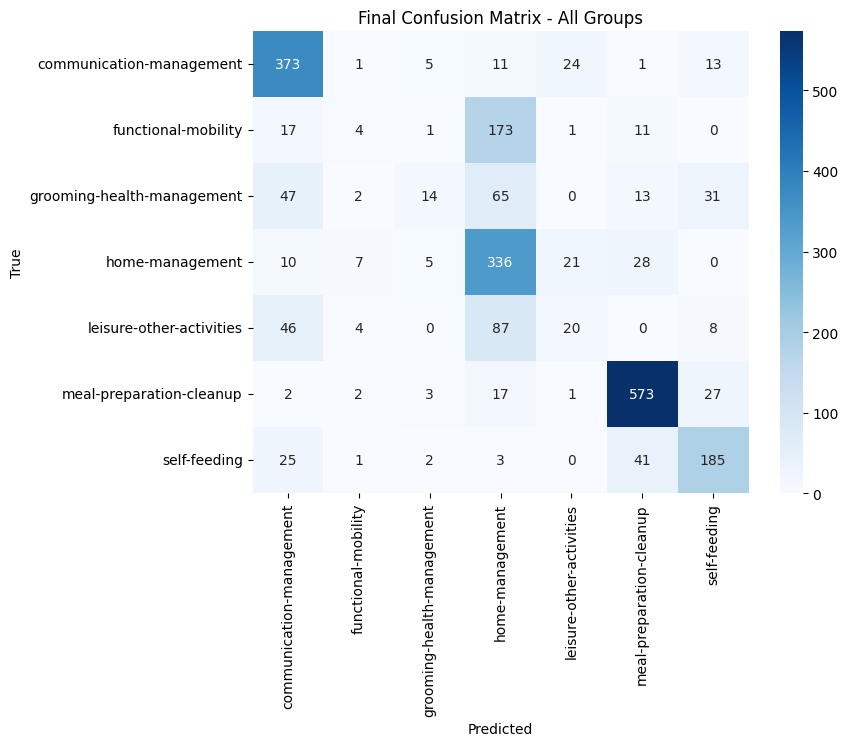

2023-11-29 11:28:21,649 - root - INFO - LOGOCV complete for RandomForestClassifier
2023-11-29 11:28:21,977 - root - INFO - Training complete for LogisticRegression, group left out: SCI02
2023-11-29 11:28:22,184 - root - INFO - Training complete for LogisticRegression, group left out: SCI03
2023-11-29 11:28:22,382 - root - INFO - Training complete for LogisticRegression, group left out: SCI06
2023-11-29 11:28:22,593 - root - INFO - Training complete for LogisticRegression, group left out: SCI08
2023-11-29 11:28:22,777 - root - INFO - Training complete for LogisticRegression, group left out: SCI10
2023-11-29 11:28:22,967 - root - INFO - Training complete for LogisticRegression, group left out: SCI11
2023-11-29 11:28:23,141 - root - INFO - Training complete for LogisticRegression, group left out: SCI12
2023-11-29 11:28:23,342 - root - INFO - Training complete for LogisticRegression, group left out: SCI13
2023-11-29 11:28:23,530 - root - INFO - Training complete for LogisticRegression, gro

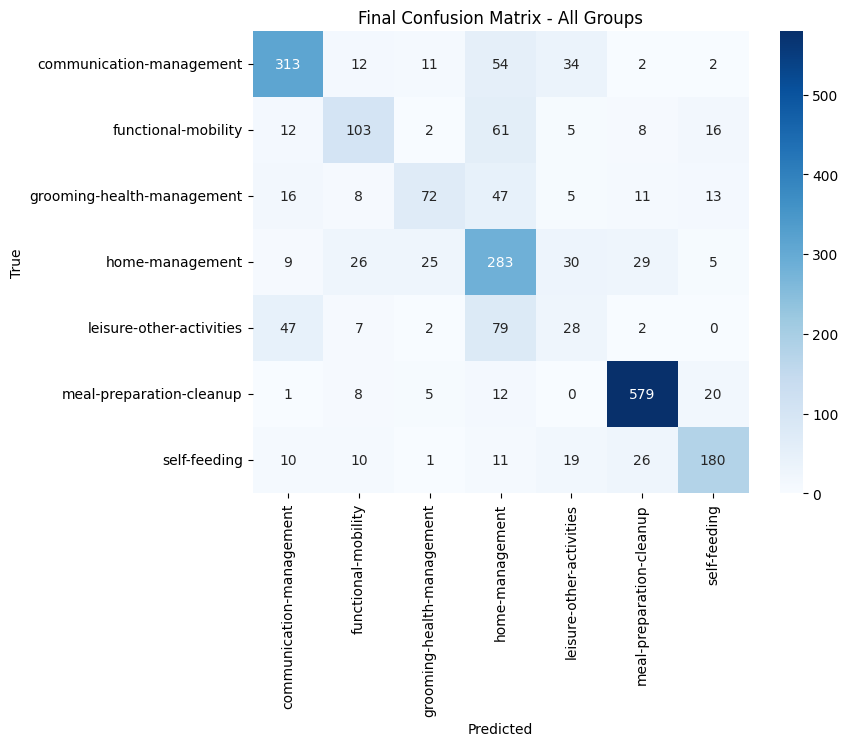

2023-11-29 11:28:25,436 - root - INFO - LOGOCV complete for LogisticRegression


In [15]:
# evaluate models using cross validation

rf_eval = ev.leave_one_group_out_cv(df, X, y, groups, rf_clf)
log_eval = ev.leave_one_group_out_cv(df, X, y, groups, log_clf)

In [16]:
rf_eval

,group_left_out,accuracy,precision,recall,f1,mean_accuracy,mean_precision,mean_recall,mean_f1
0,SCI02,0.875000,0.873171,0.392982,0.420460,0.670257,0.631389,0.591094,0.468467
1,SCI03,0.765625,0.707090,0.561920,0.326276,0.670257,0.631389,0.591094,0.468467
2,SCI06,0.640777,0.469375,0.300649,0.550078,0.670257,0.631389,0.591094,0.468467
3,SCI08,0.571429,0.666667,0.666667,0.333333,0.670257,0.631389,0.591094,0.468467
4,SCI10,0.183486,0.438492,0.658009,0.174661,0.670257,0.631389,0.591094,0.468467
5,SCI11,0.742424,0.687398,0.384317,0.390881,0.670257,0.631389,0.591094,0.468467
6,SCI12,0.740909,0.488212,0.596707,0.800379,0.670257,0.631389,0.591094,0.468467
7,SCI13,0.666667,0.575866,0.652578,0.337965,0.670257,0.631389,0.591094,0.468467
8,SCI14,0.608696,0.627502,0.521725,0.401038,0.670257,0.631389,0.591094,0.468467
9,SCI15,0.905882,0.932365,0.639907,0.655776,0.670257,0.631389,0.591094,0.468467


In [17]:
log_eval

,group_left_out,accuracy,precision,recall,f1,mean_accuracy,mean_precision,mean_recall,mean_f1
0,SCI02,0.947917,0.881892,0.466667,0.470734,0.701614,0.528573,0.657077,0.511502
1,SCI03,0.828125,0.625837,0.694516,0.521098,0.701614,0.528573,0.657077,0.511502
2,SCI06,0.660194,0.621308,0.334632,0.594771,0.701614,0.528573,0.657077,0.511502
3,SCI08,0.571429,0.666667,0.666667,0.333333,0.701614,0.528573,0.657077,0.511502
4,SCI10,0.541284,0.291592,0.772670,0.209265,0.701614,0.528573,0.657077,0.511502
5,SCI11,0.787879,0.478204,0.429051,0.576093,0.701614,0.528573,0.657077,0.511502
6,SCI12,0.659091,0.543651,0.629978,0.541199,0.701614,0.528573,0.657077,0.511502
7,SCI13,0.531073,0.407181,0.667442,0.421036,0.701614,0.528573,0.657077,0.511502
8,SCI14,0.755435,0.583689,0.656038,0.682316,0.701614,0.528573,0.657077,0.511502
9,SCI15,0.900000,0.552713,0.726882,0.735414,0.701614,0.528573,0.657077,0.511502
